In [1]:
import numpy as np
import pandas as pd
import os
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Load the main album and year data
albums_df = pd.read_csv('dataset/Album_Lists.csv')

# Directory containing the albums
album_dir = 'dataset'

# List to hold track data
track_data = []

# Expected columns in each album CSV
expected_columns = ['ID', 'Tracks']

# Iterate through each album file and load track data
for album in albums_df['Album']:
    album_file = os.path.join(album_dir, album, f'{album}.csv')
    if os.path.exists(album_file):
        try:
            album_tracks = pd.read_csv(album_file)
            if 'Unnamed: 0' in album_tracks.columns:
                album_tracks = album_tracks.drop(columns=['Unnamed: 0'])  # Drop the unnecessary column
            for col in expected_columns:
                if col not in album_tracks.columns:
                    album_tracks[col] = None

            album_tracks = album_tracks[expected_columns]  # Keep only expected columns
            album_tracks['Album'] = album  # Add the album name to each track entry
            track_data.append(album_tracks)
        except Exception as e:
            print(f"Error reading {album_file}: {e}")
    else:
        print(f"File not found: {album_file}")

# Combine all track data into a single DataFrame
tracks_df = pd.concat(track_data, ignore_index=True)

print(f"Combined DataFrame:\n{tracks_df.head(100)}")

Combined DataFrame:
          ID                                Tracks  \
0   10024009                             Fortnight   
1   10024578         The Tortured Poets Department   
2   10024528  My Boy Only Breaks His Favorite Toys   
3   10024535                              Down Bad   
4   10024536                       So Long, London   
..       ...                                   ...   
95   6688213                Mine (Taylors Version)   
96   6688225          Sparks Fly (Taylors Version)   
97   6688226    Back To December (Taylors Version)   
98   6688227           Speak Now (Taylors Version)   
99   6688228           Dear John (Taylors Version)   

                             Album  
0   The Tortured Poets Departement  
1   The Tortured Poets Departement  
2   The Tortured Poets Departement  
3   The Tortured Poets Departement  
4   The Tortured Poets Departement  
..                             ...  
95                       Speak Now  
96                       Speak Now 

In [3]:
def format_track_name(track_name):
    # Replace non-alphanumeric characters with underscores and remove spaces
    formatted_name = re.sub(r'[^A-Za-z0-9]+', '_', track_name.replace(' ', ''))
    return formatted_name

# Apply the function to create a new column for formatted track names
tracks_df['formatted_track_name'] = tracks_df['Tracks'].apply(format_track_name)

# Function to load lyrics from a text file based on the formatted track name
def load_lyrics(formatted_track_name):
    for album in albums_df['Album']:
        lyric_file = os.path.join(album_dir, album, f'{formatted_track_name}.txt')
        if os.path.exists(lyric_file):
            try:
                with open(lyric_file, 'r', encoding='utf-8') as file:
                    lyrics = file.read()
                    # Remove the first line of the lyrics
                    lyrics = '\n'.join(lyrics.split('\n')[1:])
                    return lyrics
            except Exception as e:
                print(f"Error reading {lyric_file}: {e}")
    return None

# Apply the function to load lyrics for each track
tracks_df['lyrics'] = tracks_df['formatted_track_name'].apply(load_lyrics)

# Filter tracks with no lyrics
tracks_with_no_lyrics = tracks_df[tracks_df['lyrics'].isna()]

print(tracks_with_no_lyrics[['Album','Tracks']])

# Merge the album data with track data
merged_df = pd.merge(tracks_df, albums_df, on='Album')

# Ensure merged DataFrame has the necessary columns
expected_columns = ['Album', 'Tracks', 'formatted_track_name', 'lyrics', 'Year']
missing_columns = [col for col in expected_columns if col not in merged_df.columns]
if missing_columns:
    raise ValueError(f"Missing columns in the merged DataFrame: {missing_columns}")

print(merged_df.head(5))

Empty DataFrame
Columns: [Album, Tracks]
Index: []
         ID                                Tracks  \
0  10024009                             Fortnight   
1  10024578         The Tortured Poets Department   
2  10024528  My Boy Only Breaks His Favorite Toys   
3  10024535                              Down Bad   
4  10024536                       So Long, London   

                            Album            formatted_track_name  \
0  The Tortured Poets Departement                       Fortnight   
1  The Tortured Poets Departement      TheTorturedPoetsDepartment   
2  The Tortured Poets Departement  MyBoyOnlyBreaksHisFavoriteToys   
3  The Tortured Poets Departement                         DownBad   
4  The Tortured Poets Departement                   SoLong_London   

                                              lyrics  Year  
0  I was supposed to be sent away\nBut they forgo...  2024  
1  You left your typewriter at my apartment\nStra...  2024  
2  Oh, here we go again\nThe voi

In [4]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize necessary tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define cleaning functions
def clean_lyrics(lyrics):
    if lyrics:
        lyrics = lyrics.lower()
        # Remove invoice
        lyrics = re.sub(r'inv/\d+/\w+/\w+/\d+', '', lyrics, flags=re.IGNORECASE)
        # Remove carriage returns and newlines
        lyrics = re.sub(r'[\r\n]', ' ', lyrics)
        # Remove mentions
        lyrics = re.sub(r'@\w+', '', lyrics)
        # Remove metadata or annotations within square brackets or parentheses
        lyrics = re.sub(r'\[.*?\]|\(.*?\)', '', lyrics)
        # Remove specific unwanted characters while keeping useful punctuation
        lyrics = re.sub(r'[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', lyrics)
        # Remove digits if they are not part of the core lyrics
        lyrics = re.sub(r'\d+', '', lyrics)
        # Remove single characters except for 'i' and 'a'
        lyrics = re.sub(r'\b(?!i\b|a\b)[a-zA-Z]\b', '', lyrics)
        # Remove filler words
        filler_words = r'\b(oh|ooh|ah|yeah|na|la|da|woo|whoa|uh|hah|hey|ho|ha|ll|ve|mm|gon|wan|gonna|wanna|ain)\b'
        lyrics = re.sub(filler_words, '', lyrics)
        # Normalize whitespace (remove extra spaces and strip leading/trailing spaces)
        lyrics = re.sub(r'\s+', ' ', lyrics).strip()
        # Remove remaining punctuation and special characters
        lyrics = re.sub(r'[^\w\s]', '', lyrics)
    return lyrics

def remove_stopwords(lyrics):
    if lyrics:
        words = lyrics.split()
        filtered_words = [word for word in words if word not in stop_words]
        return ' '.join(filtered_words)
    return lyrics

def tokenize_and_lemmatize(lyrics):
    if lyrics:
        tokens = word_tokenize(lyrics)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)
    return lyrics

# Apply cleaning functions to the lyrics column
def preprocess_lyrics(lyrics):
    if lyrics:
        lyrics = clean_lyrics(lyrics)
        lyrics = remove_stopwords(lyrics)
        lyrics = tokenize_and_lemmatize(lyrics)
    return lyrics

merged_df['processed_lyrics'] = merged_df['lyrics'].apply(preprocess_lyrics)

# Assign thematic categories based on albums
thematic_categories = {
    'Fearless': 'Growth, Overcoming Challenges',
    '1989': 'New Beginnings, Freedom',
    'Red': 'Relationships, Emotional Turmoil',
    'Lover': 'Joy, Commitment',
    'Folklore': 'Reflection, Storytelling',
    'evermore': 'Nostalgia, Melancholy',
    'Reputation': 'Resilience, Defiance',
    'Midnights': 'Introspection, Restlessness',
    'Taylor Swift': 'Coming of Age, Discovery',
    'Speak Now': 'Personal Growth, Confessions',
    'The Tortured Poets Departement': 'Introspection, Artistic Struggle'
}

merged_df['Thematic_Category'] = merged_df['Album'].map(thematic_categories)

print(merged_df.head(5))

# Testing the function with a sample lyric
sample_lyrics = "We could leave the Christmas lights up 'til January And this is our place, we make the rules And there's a dazzling haze, a mysterious way about you, dear Have I known you twenty seconds or twenty years? [Chorus] Can I go where you go? Can we always be this close? Forever and ever, ah Take me out and take me home You're my, my, my, my lover"
print("Processed Lyrics:", preprocess_lyrics(sample_lyrics))

[nltk_data] Downloading package stopwords to /home/ayusee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ayusee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ayusee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


         ID                                Tracks  \
0  10024009                             Fortnight   
1  10024578         The Tortured Poets Department   
2  10024528  My Boy Only Breaks His Favorite Toys   
3  10024535                              Down Bad   
4  10024536                       So Long, London   

                            Album            formatted_track_name  \
0  The Tortured Poets Departement                       Fortnight   
1  The Tortured Poets Departement      TheTorturedPoetsDepartment   
2  The Tortured Poets Departement  MyBoyOnlyBreaksHisFavoriteToys   
3  The Tortured Poets Departement                         DownBad   
4  The Tortured Poets Departement                   SoLong_London   

                                              lyrics  Year  \
0  I was supposed to be sent away\nBut they forgo...  2024   
1  You left your typewriter at my apartment\nStra...  2024   
2  Oh, here we go again\nThe voices in his head\n...  2024   
3  Did you really 

In [5]:
from textblob import TextBlob
import plotly.express as px

# Function to calculate sentiment
def calculate_sentiment(lyrics):
    if lyrics:
        blob = TextBlob(lyrics)
        return blob.sentiment.polarity  # Returns a polarity score between -1 and 1
    return 0

# Apply sentiment analysis to the lyrics
merged_df['sentiment'] = merged_df['processed_lyrics'].apply(calculate_sentiment)
print(merged_df[['Tracks', 'sentiment']].head())

# An interactive bar chart for sentiment distribution by album
fig = px.bar(merged_df, x='Album', y='sentiment', title='Sentiment Distribution by Album',
             labels={'sentiment': 'Average Sentiment', 'Album': 'Album'},
             color='Album',  # Color code by thematic category
             barmode='group')

fig.show()

# A scatter plot showing sentiment and year
fig2 = px.scatter(merged_df, x='Year', y='sentiment', color='Thematic_Category',
                  title='Sentiment by Year and Thematic Category',
                  labels={'sentiment': 'Sentiment Score', 'Year': 'Release Year'},
                  hover_data=['Tracks', 'Album'])  # Additional data to show on hover

fig2.show()


                                 Tracks  sentiment
0                             Fortnight   0.357424
1         The Tortured Poets Department   0.011765
2  My Boy Only Breaks His Favorite Toys   0.271786
3                              Down Bad  -0.258000
4                       So Long, London   0.143102


In [6]:
# Initialize the TF-IDF vectorizer with bi-grams and tri-grams
tfidf_vectorizer = TfidfVectorizer(max_features=5000, token_pattern=r'[a-zA-Z]+', max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the processed lyrics
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['processed_lyrics'].dropna())

# Convert the TF-IDF matrix to a DataFrame for easier inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(tfidf_df.head(10))

# Checking size of dataset for topic modelling
# Load data 'merged_df' that contains lyrics
documents = merged_df['processed_lyrics'].dropna().tolist()

# Number of documents
num_documents = len(documents)

# Vocabulary size
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)
vocab_size = len(vectorizer.get_feature_names_out())

# Total volume of text
total_words = sum(len(doc.split()) for doc in documents)

print(f"Number of Documents: {num_documents}")
print(f"Vocabulary Size: {vocab_size}")
print(f"Total Volume of Text (words): {total_words}")

   accident  account  ace  achilles  acid  act  actress  actually  add  \
0       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
1       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
2       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
3       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
4       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
5       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
6       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
7       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
8       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.072465  0.0   
9       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   

   addicted  ...  yeahembed     year       yes  yesterday  york  youembed  \
0       0.0  ...        0.0  0.00000  0.000000        0.0   0.0  0.057406   
1       0.0  ...        0.0  0.

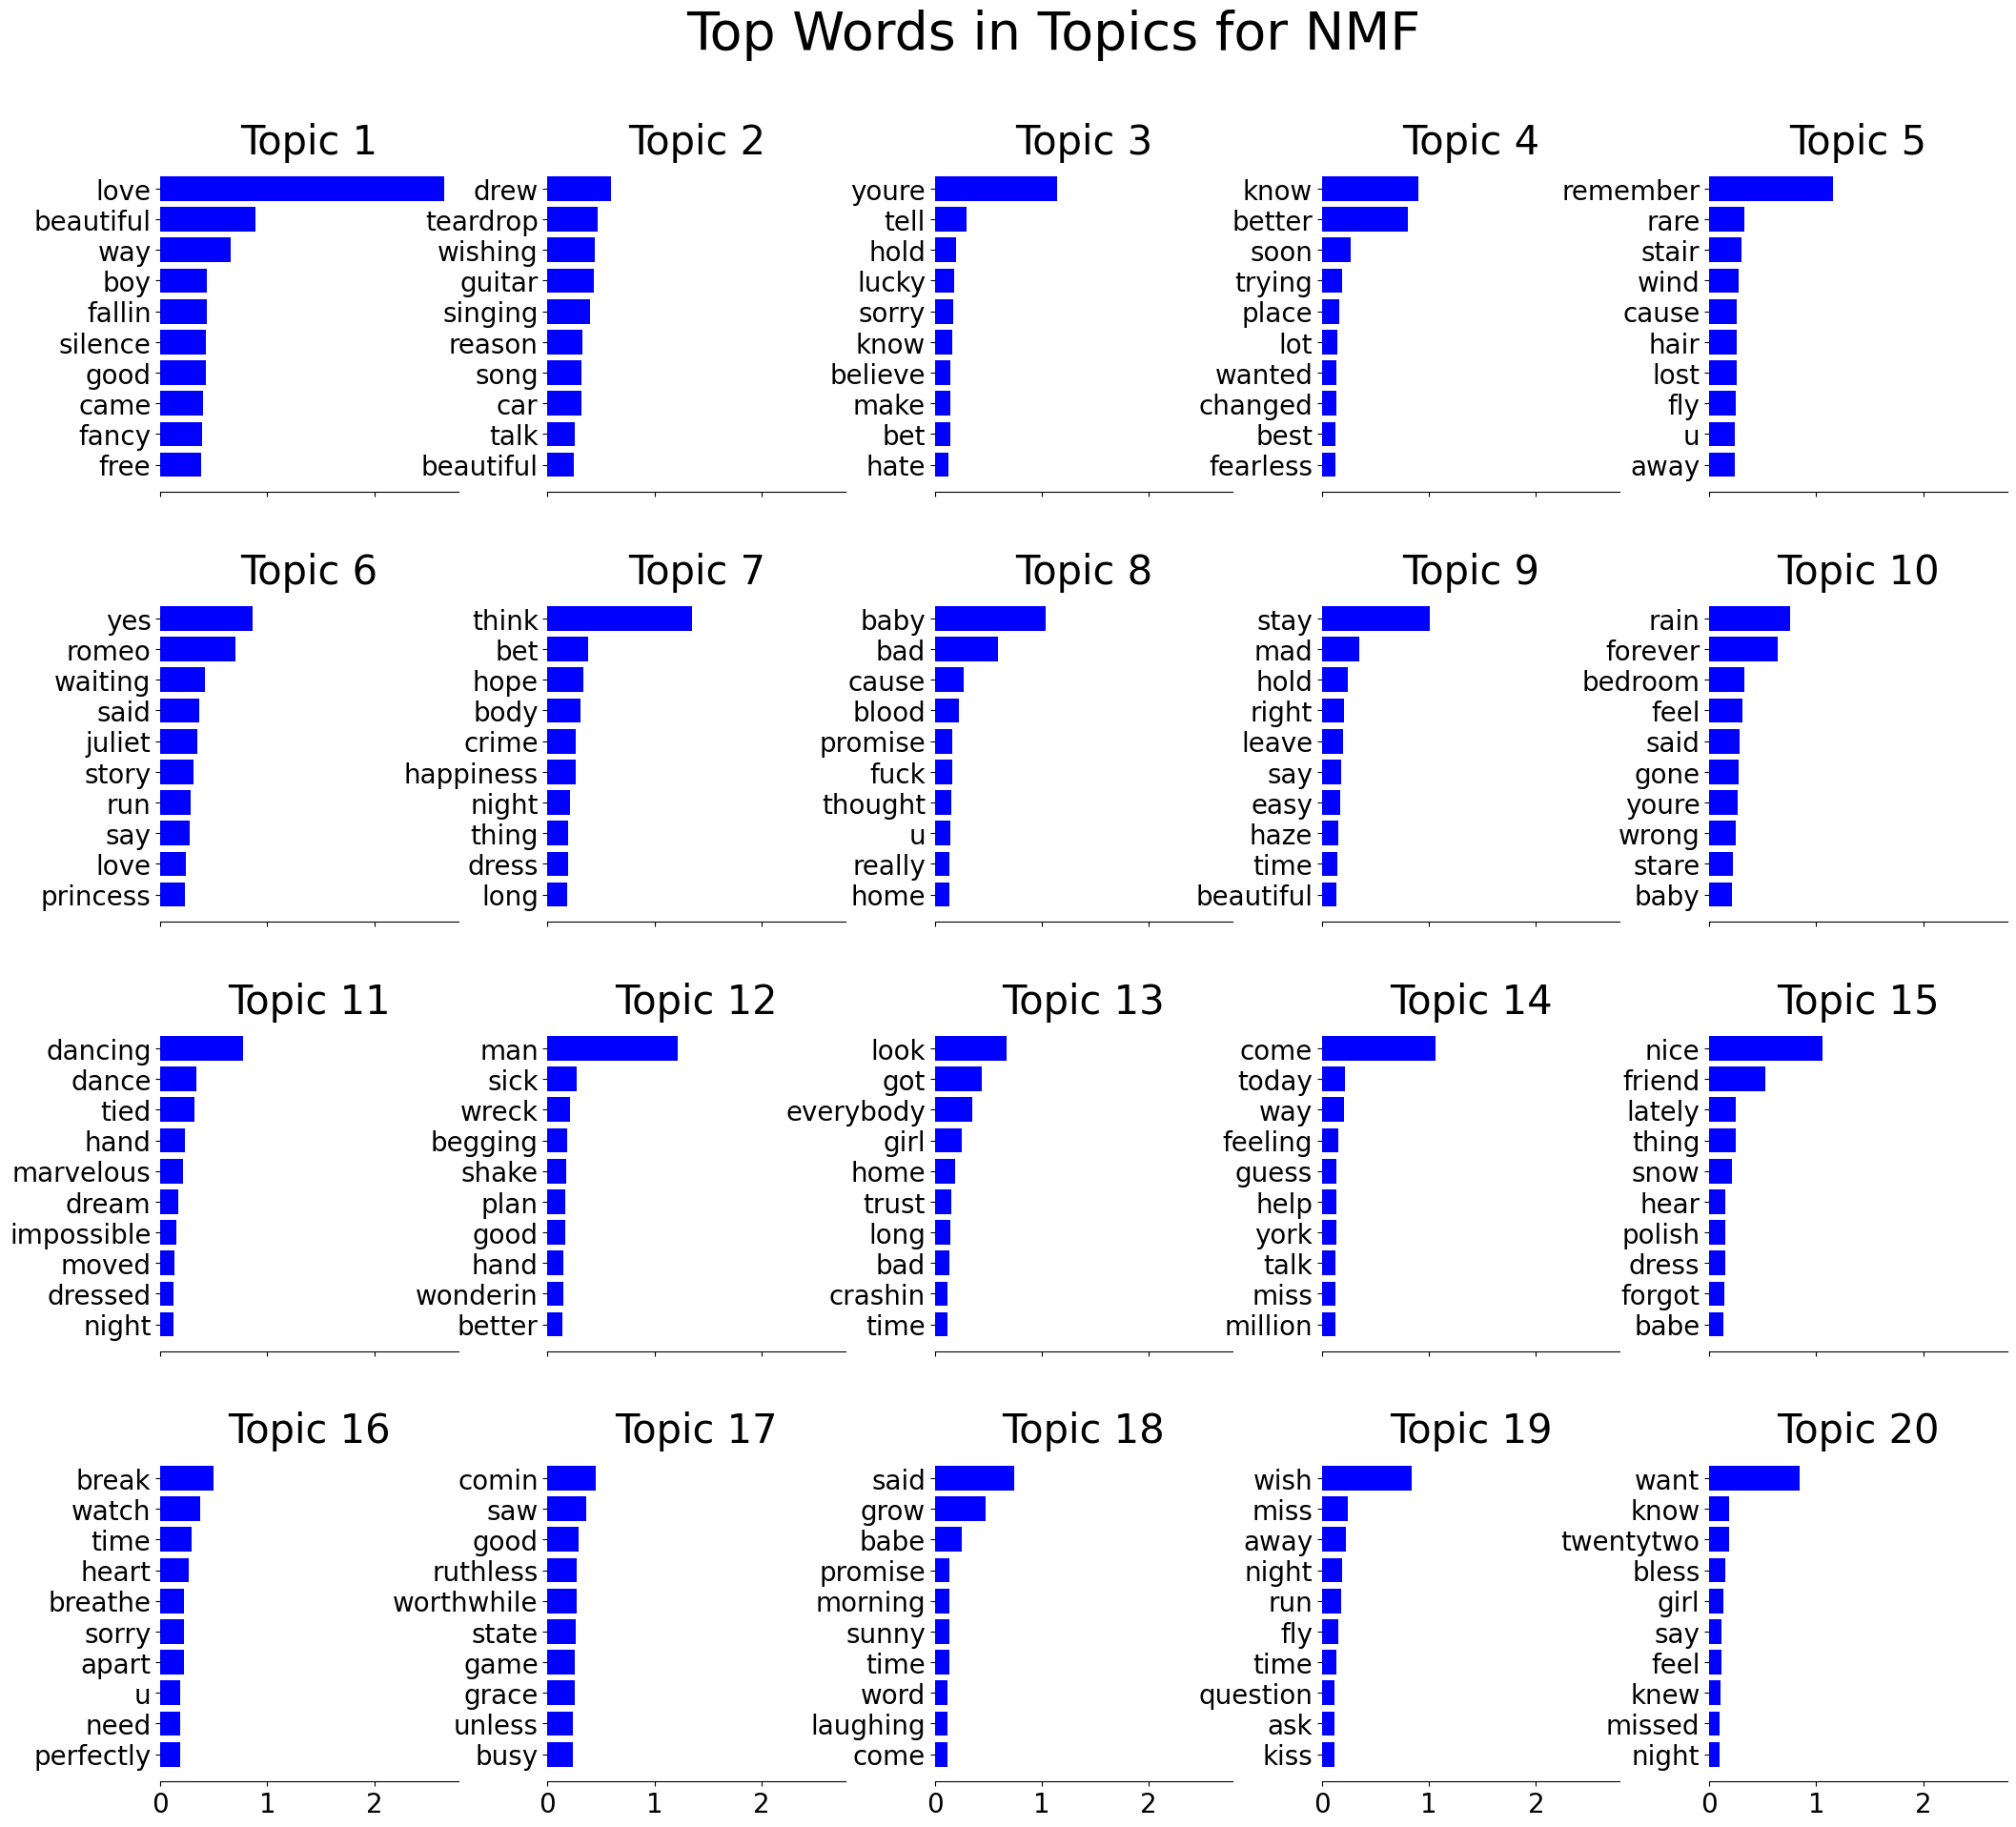

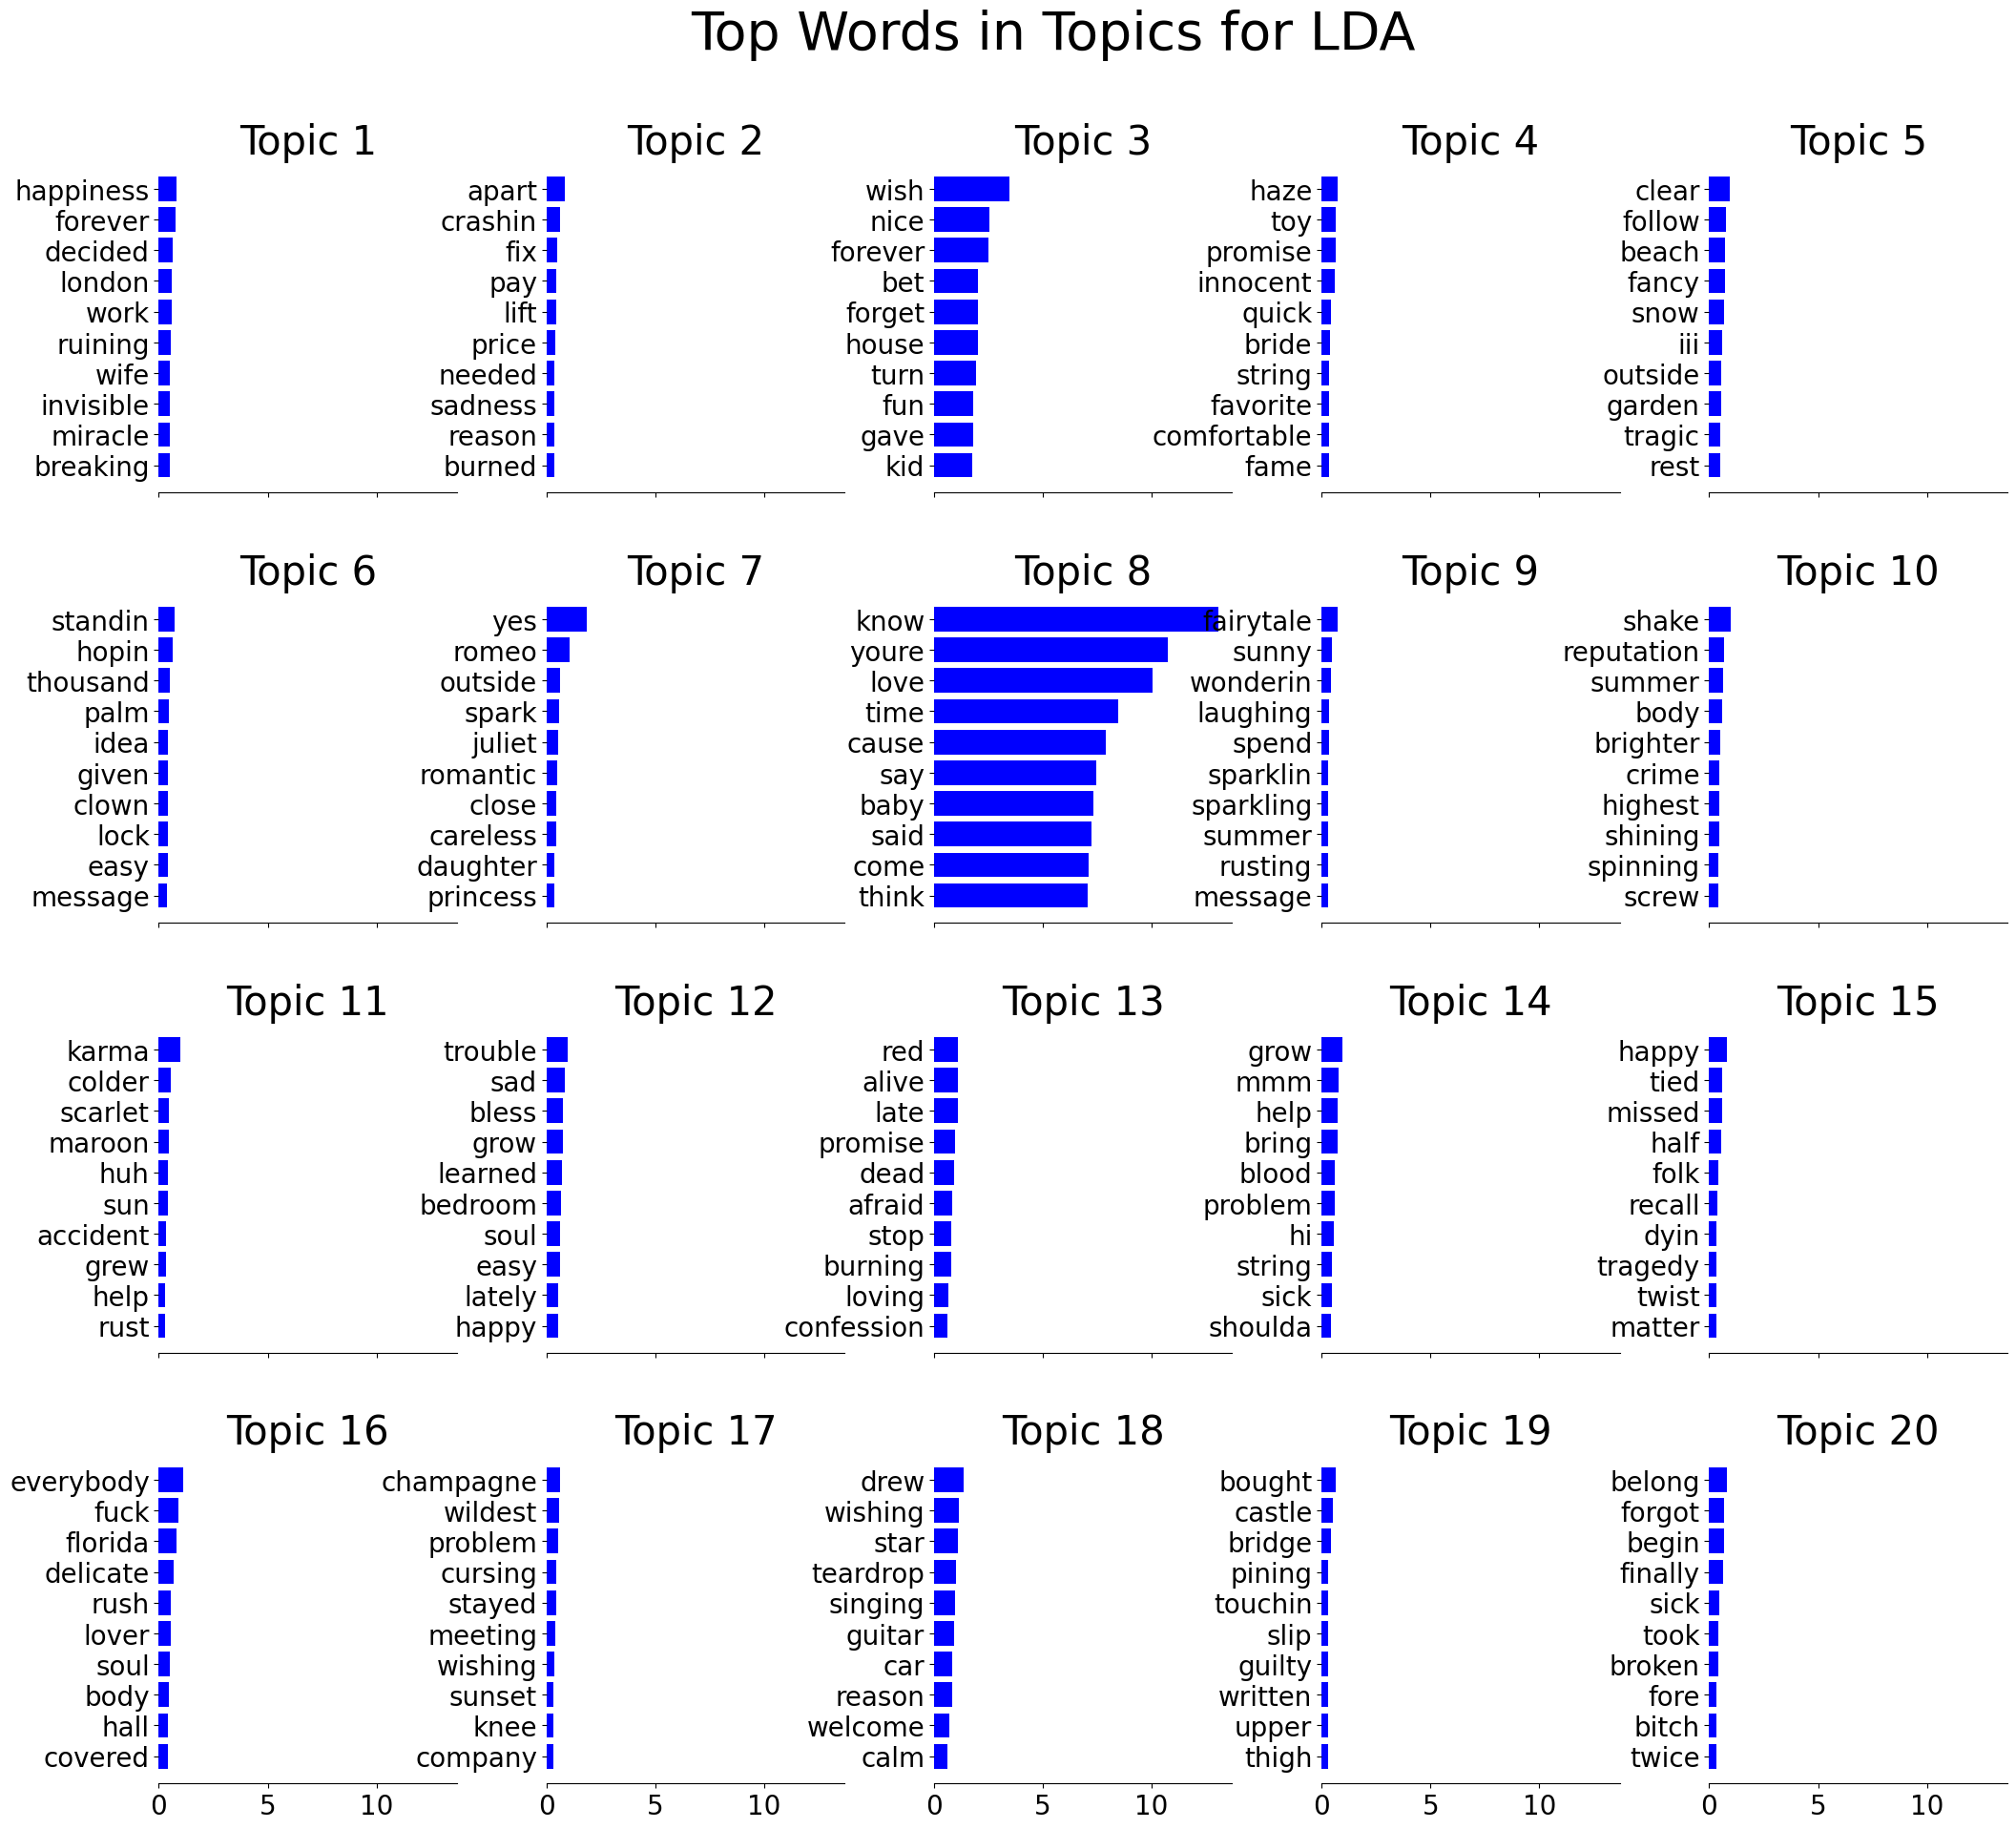

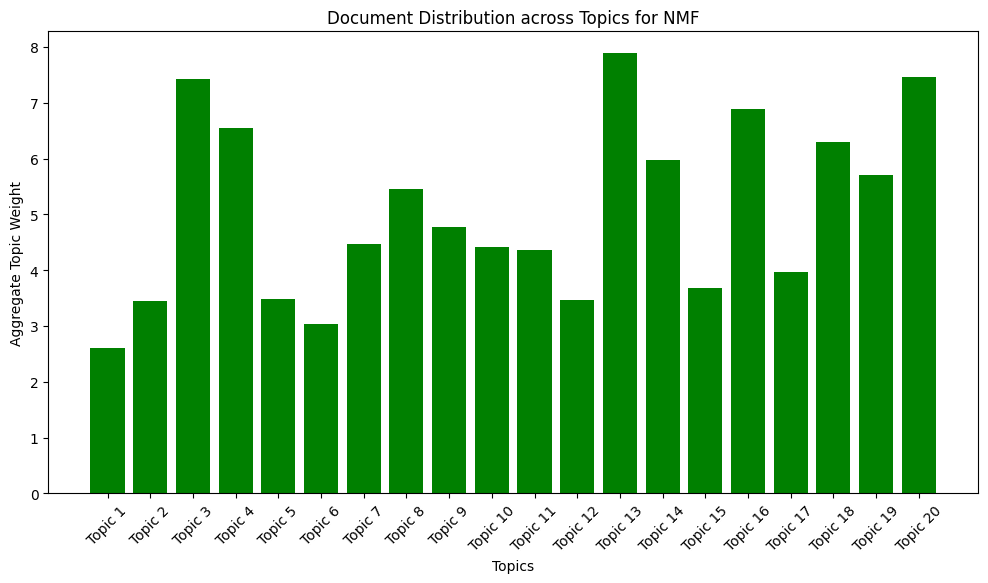

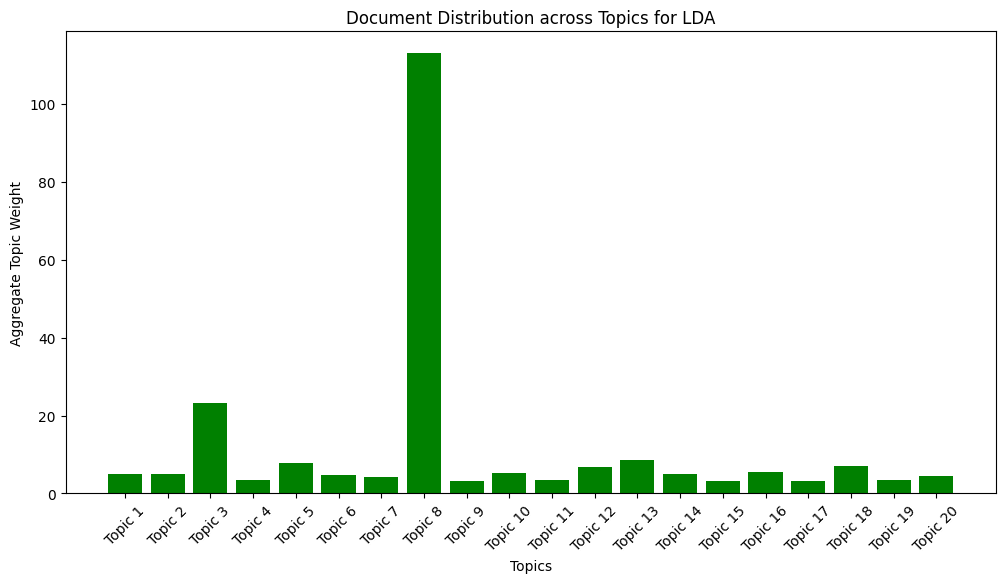

In [7]:
# Topic Modeling - NMF
nmf_model = NMF(n_components=20, max_iter=300, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# Topic Modeling - LDA
lda_model = LatentDirichletAllocation(n_components=20, max_iter=300, learning_method='batch', random_state=0)
lda_topics = lda_model.fit_transform(tfidf_matrix)

# Visualizing the Top Words for Each Topic
def plot_top_words(model, feature_names, n_top_words, title, n_cols=5):
    n_topics = len(model.components_)
    n_rows = (n_topics + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='blue')
        ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
            
    plt.subplots_adjust(top=0.90, bottom=0.05, hspace=0.3, wspace=0.3)
    fig.suptitle(title, fontsize=40)
    plt.show()
    
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf_model, tfidf_feature_names, 10, 'Top Words in Topics for NMF')
plot_top_words(lda_model, tfidf_feature_names, 10, 'Top Words in Topics for LDA')

# Visualizing Document Distribution Over Topics
def plot_document_topics(model_output, title):
    # Aggregate the topic distribution for visualization
    topic_distribution = np.sum(model_output, axis=0)
    topic_indices = [f"Topic {i+1}" for i in range(len(topic_distribution))]
    
    plt.figure(figsize=(12, 6))
    plt.bar(topic_indices, topic_distribution, color='green')
    plt.xlabel('Topics')
    plt.ylabel('Aggregate Topic Weight')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_document_topics(nmf_topics, 'Document Distribution across Topics for NMF')
plot_document_topics(lda_topics, 'Document Distribution across Topics for LDA')

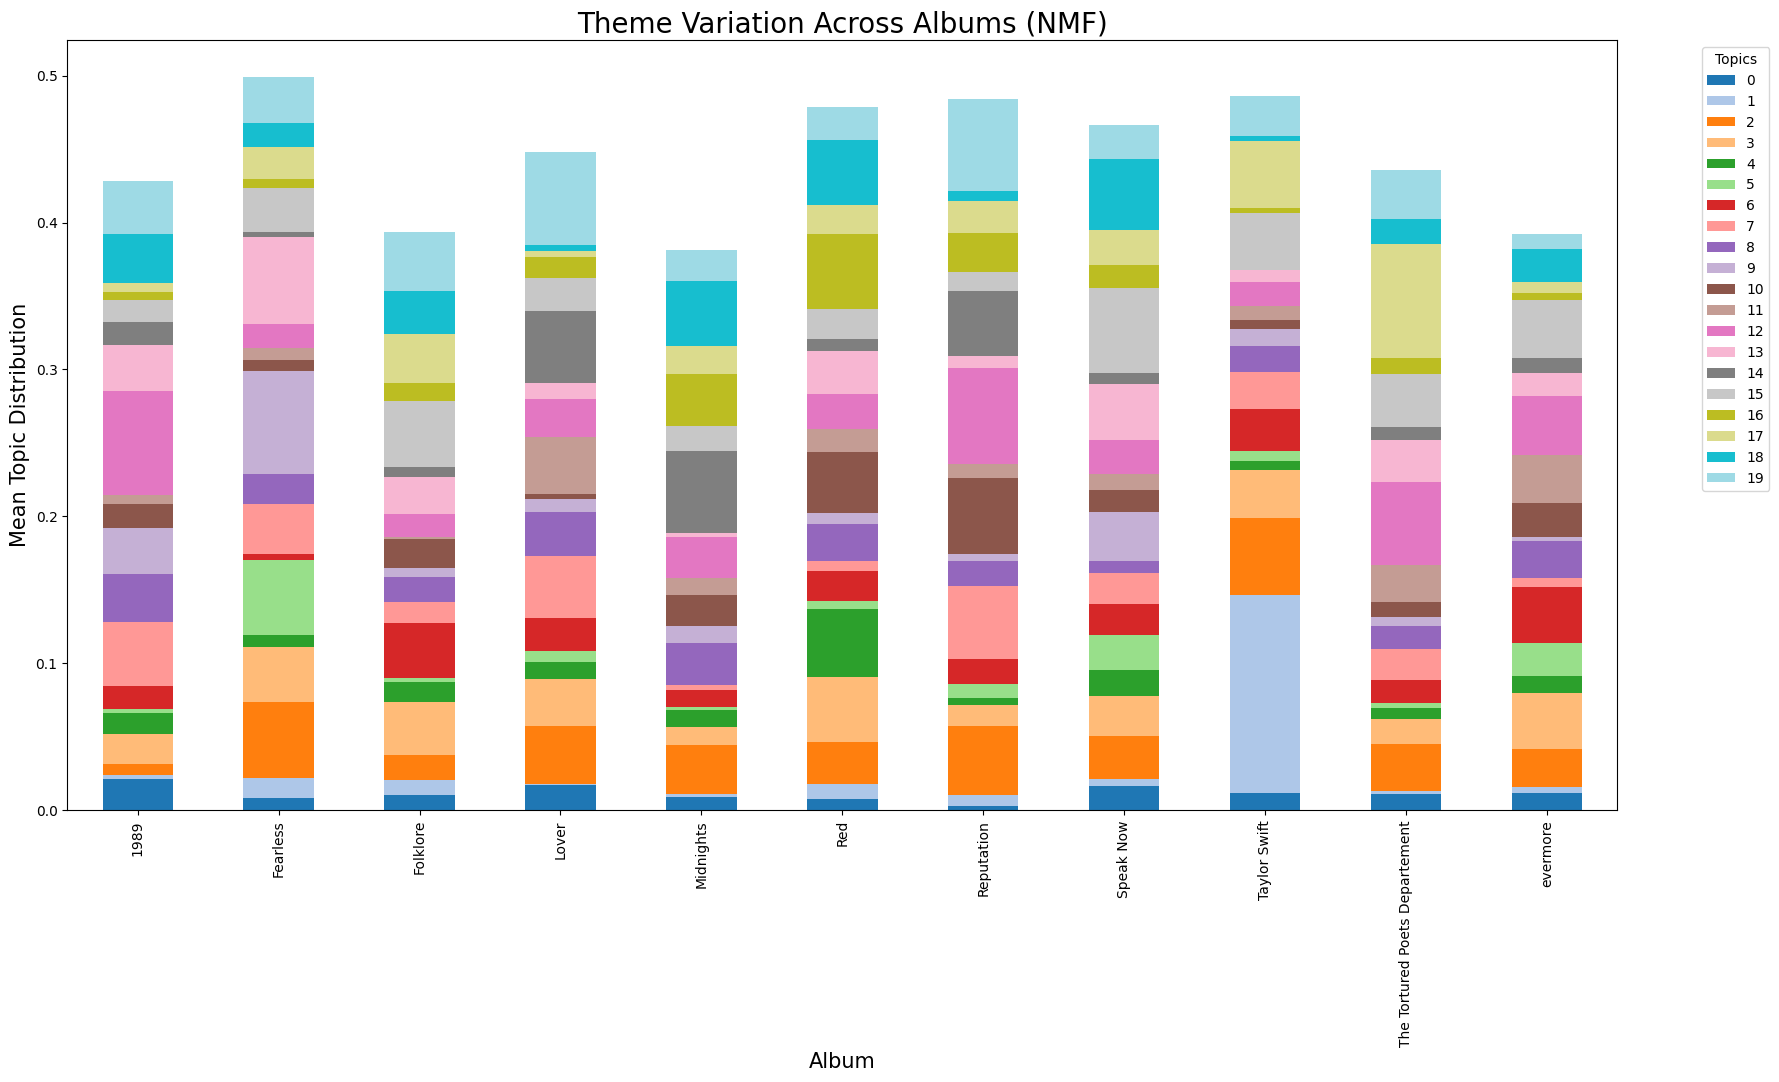

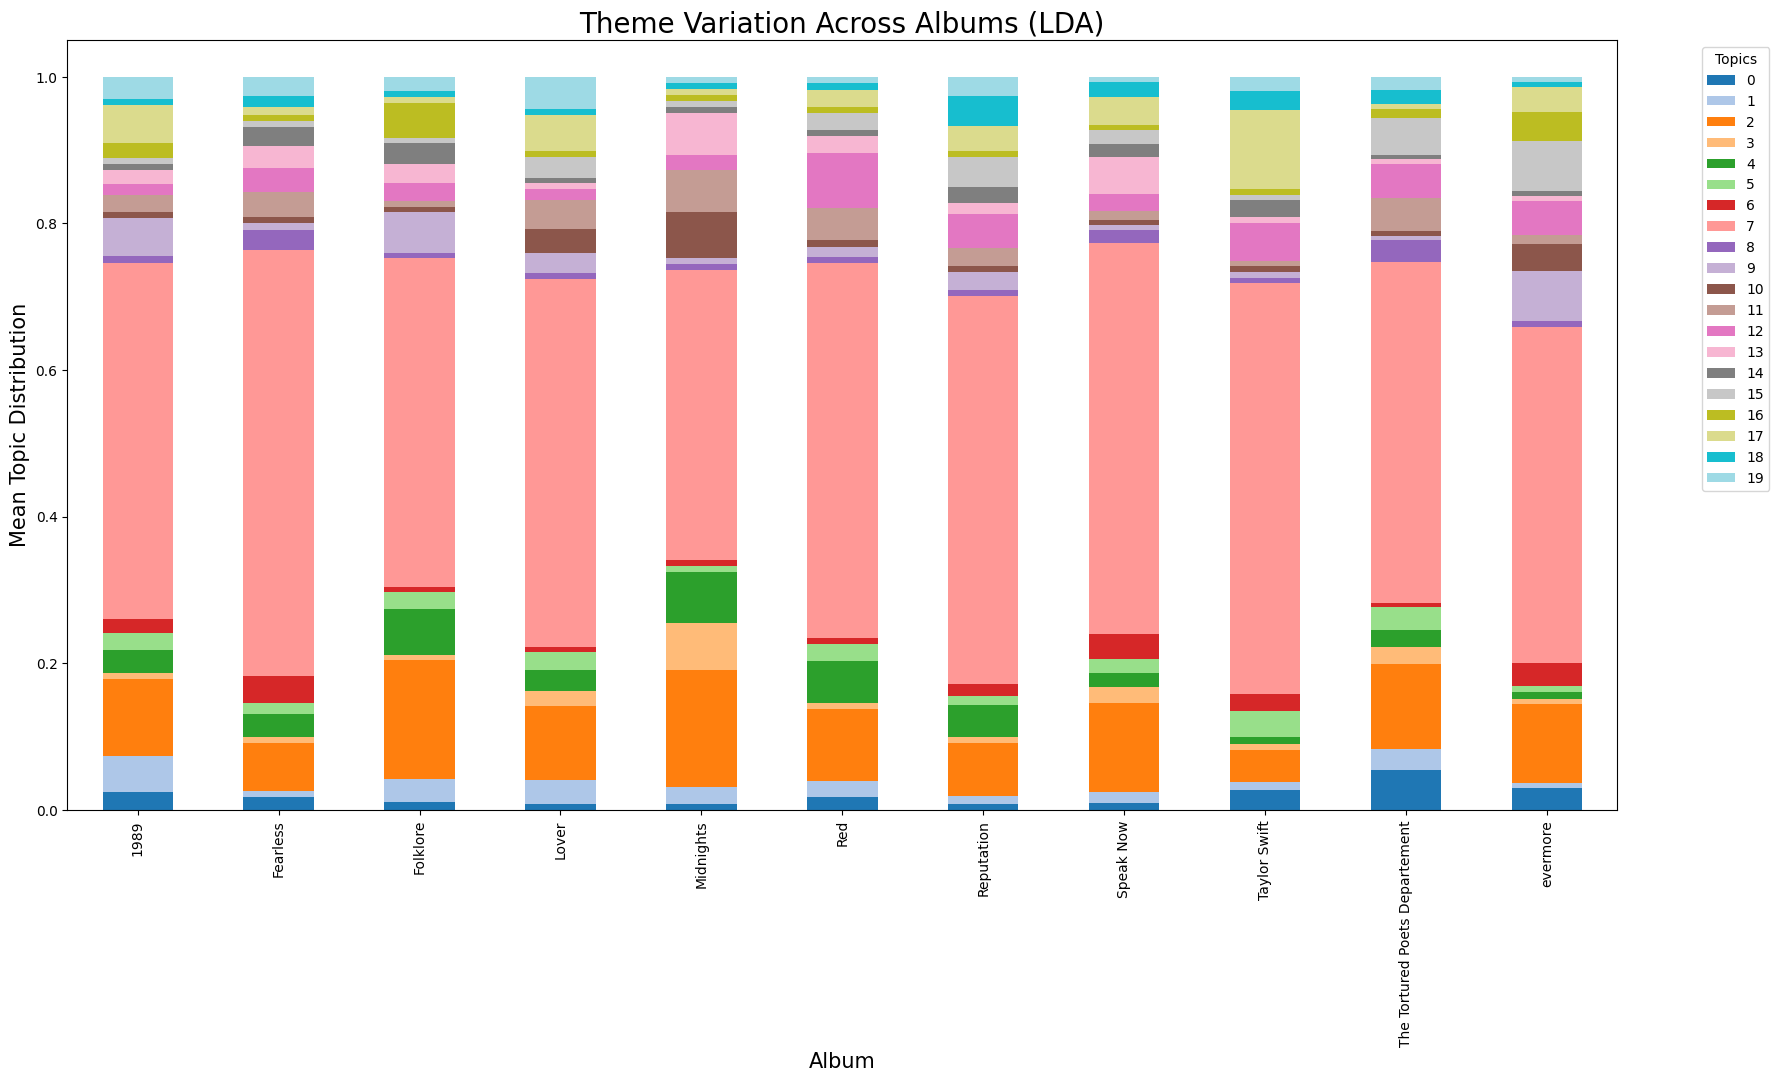

In [8]:
# Analyze theme variation across different albums
merged_df_nmf = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(nmf_topics)], axis=1)
merged_df_lda = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(lda_topics)], axis=1)

# Ensure only numeric columns are considered
numeric_columns_nmf = merged_df_nmf.select_dtypes(include=[np.number]).columns
numeric_columns_lda = merged_df_lda.select_dtypes(include=[np.number]).columns

# Group by album and calculate mean topic distribution
album_nmf_distribution = merged_df_nmf.groupby('Album')[numeric_columns_nmf].mean().iloc[:, -20:]
album_lda_distribution = merged_df_lda.groupby('Album')[numeric_columns_lda].mean().iloc[:, -20:]

# Plotting theme variation across albums
def plot_theme_variation(album_distribution, model_name):
    album_distribution.plot(kind='bar', stacked=True, figsize=(20, 10), colormap='tab20')
    plt.title(f'Theme Variation Across Albums ({model_name})', fontsize=20)
    plt.xlabel('Album', fontsize=15)
    plt.ylabel('Mean Topic Distribution', fontsize=15)
    plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_theme_variation(album_nmf_distribution, 'NMF')
plot_theme_variation(album_lda_distribution, 'LDA')

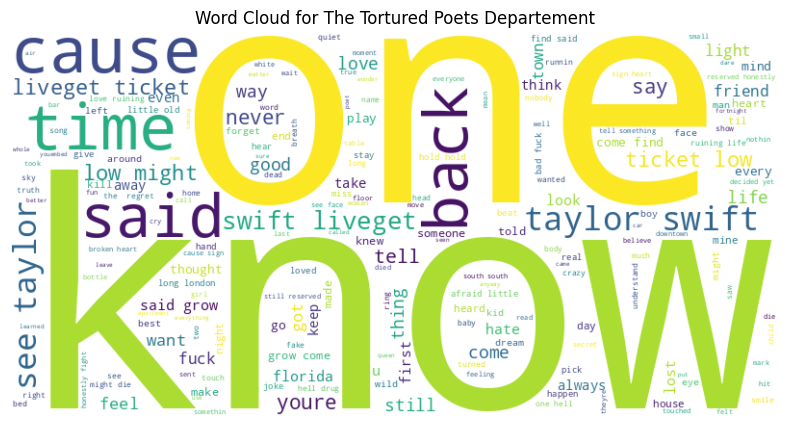

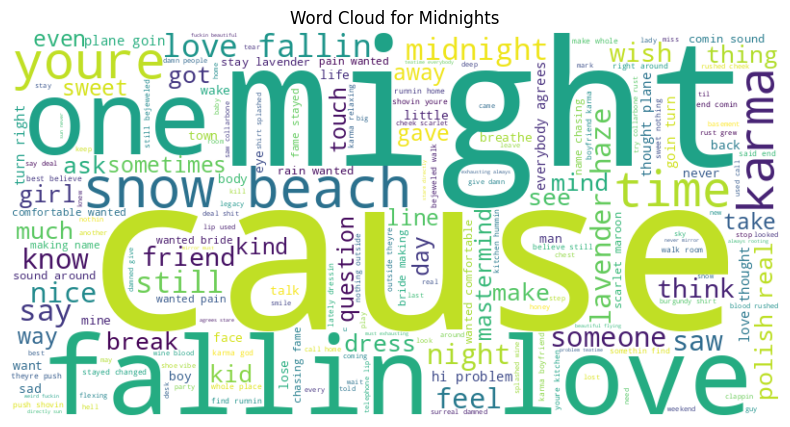

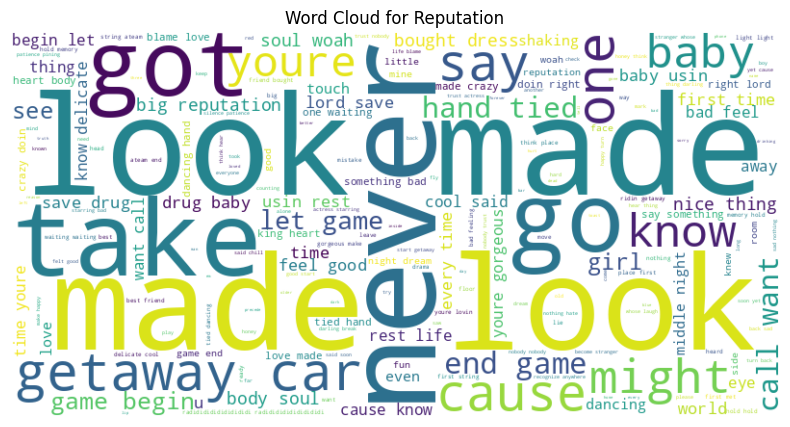

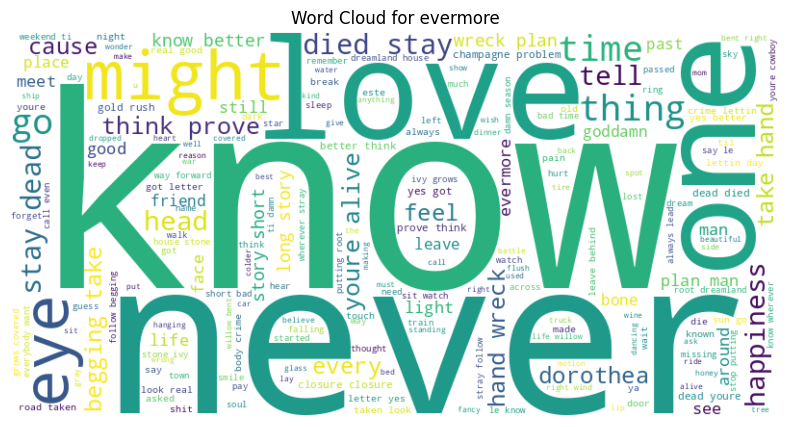

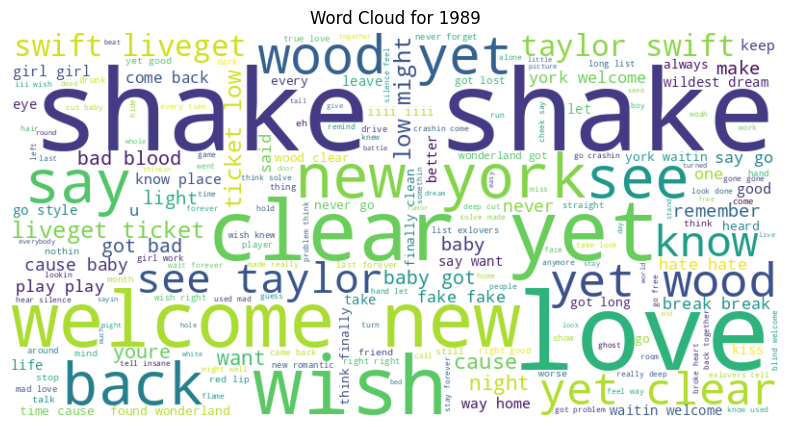

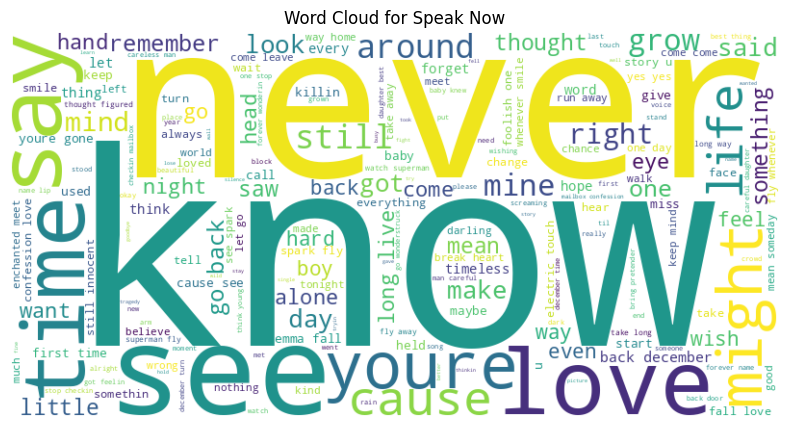

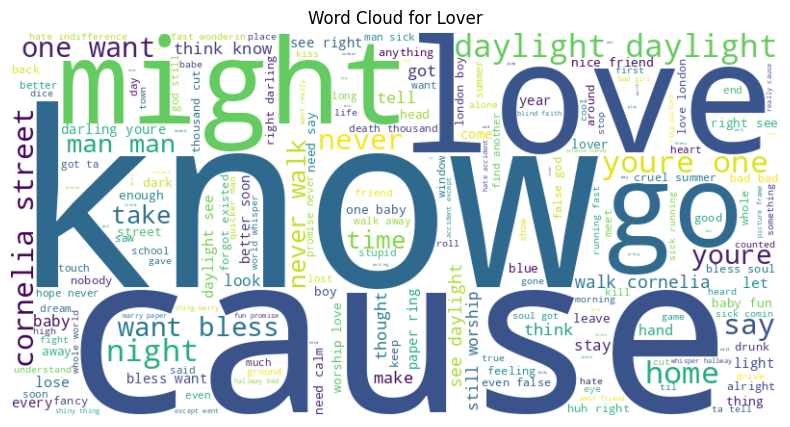

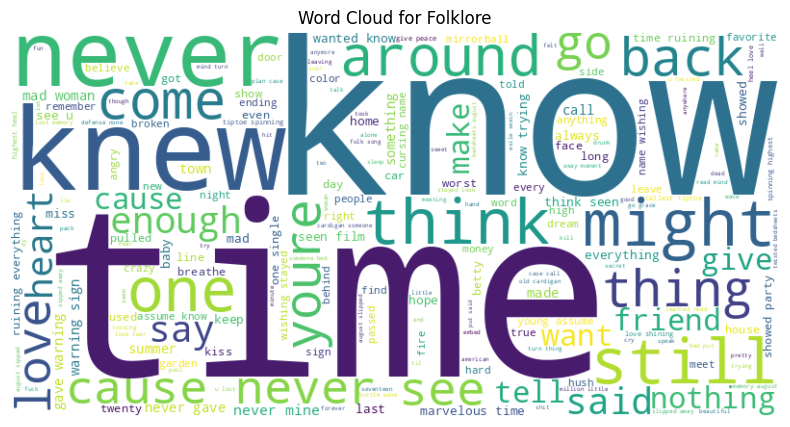

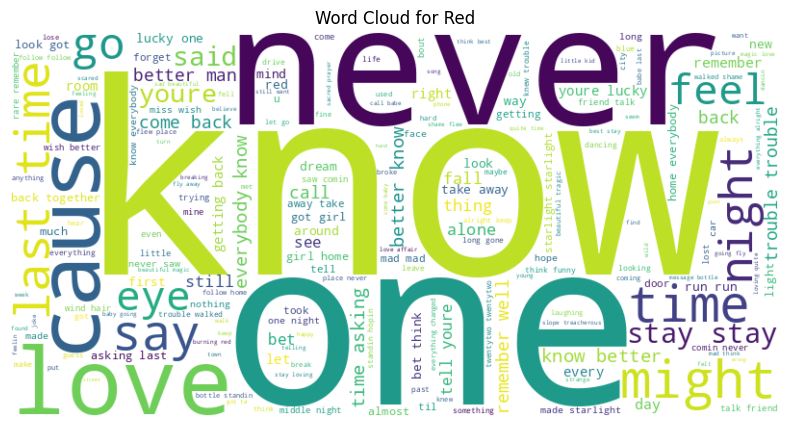

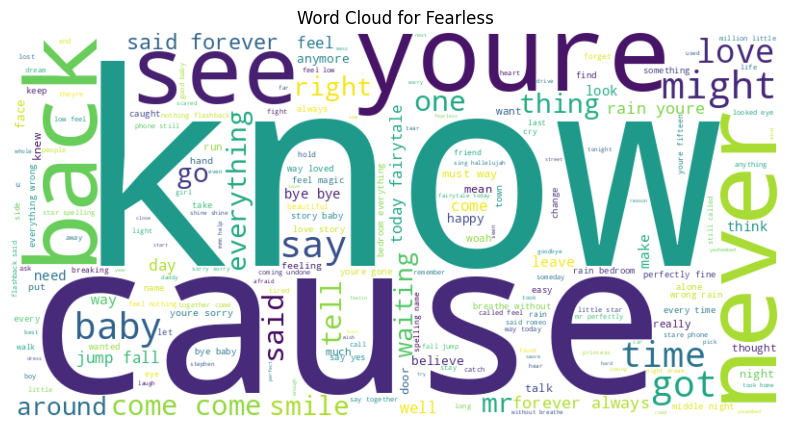

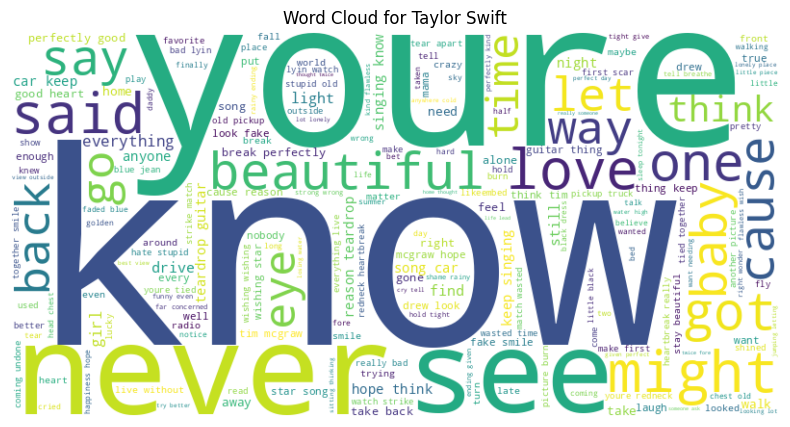

In [9]:
# Word Cloud Visualization for themes in each album
for album in merged_df['Album'].unique():
    album_lyrics = ' '.join(merged_df[merged_df['Album'] == album]['processed_lyrics'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(album_lyrics)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {album}')
    plt.show()

In [10]:
# Use only NMF features
X_nmf = nmf_topics

# Encode the target variables
label_encoder_album = LabelEncoder()
label_encoder_year = LabelEncoder()
label_encoder_thematic_category = LabelEncoder()
y_album_encoded = label_encoder_album.fit_transform(merged_df['Album'])
y_year_encoded = label_encoder_year.fit_transform(merged_df['Year'])
y_thematic_category_encoded = label_encoder_thematic_category.fit_transform(merged_df['Thematic_Category'])

# Balance the classes using SMOTE
smote = SMOTE(random_state=42)
X_nmf_balanced_album, y_album_balanced = smote.fit_resample(X_nmf, y_album_encoded)
X_nmf_balanced_year, y_year_balanced = smote.fit_resample(X_nmf, y_year_encoded)
X_nmf_balanced_thematic, y_thematic_balanced = smote.fit_resample(X_nmf, y_thematic_category_encoded)

# Applying PCA to the balanced datasets
pca = PCA(n_components=20, random_state=42)
X_nmf_pca_album = pca.fit_transform(X_nmf_balanced_album)
X_nmf_pca_year = pca.fit_transform(X_nmf_balanced_year)
X_nmf_pca_thematic = pca.fit_transform(X_nmf_balanced_thematic)

# Train-test split with stratification to maintain the distribution of classes
X_train_album, X_test_album, y_train_album, y_test_album = train_test_split(X_nmf_pca_album, y_album_balanced, test_size=0.2, random_state=42, stratify=y_album_balanced)
X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(X_nmf_pca_year, y_year_balanced, test_size=0.2, random_state=42, stratify=y_year_balanced)
X_train_thematic, X_test_thematic, y_train_thematic, y_test_thematic = train_test_split(X_nmf_pca_thematic, y_thematic_balanced, test_size=0.2, random_state=42, stratify=y_thematic_balanced)

In [11]:
# Random Forest
# Expanded Random Forest parameter grid for RandomizedSearchCV instead of GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'bootstrap': [True, False]
}

# Function to evaluate model performance
def evaluate_model(y_true, y_pred, task_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"Performance metrics for {task_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

# Album Prediction with Random Forest using RandomizedSearchCV
rf_clf_album = RandomForestClassifier(random_state=42)
rf_random_search_album = RandomizedSearchCV(rf_clf_album, rf_param_grid, n_iter=100, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1, random_state=42)
rf_random_search_album.fit(X_train_album, y_train_album)
best_rf_model_album = rf_random_search_album.best_estimator_

# Predicting with the best Random Forest model
y_pred_rf_album = best_rf_model_album.predict(X_test_album)

# Decode the predictions back to original labels
y_pred_rf_album_decoded = label_encoder_album.inverse_transform(y_pred_rf_album)

# Evaluate the Random Forest model performance
evaluate_model(y_test_album, y_pred_rf_album, 'Album Prediction with Random Forest')

# Year Prediction with Random Forest using RandomizedSearchCV
rf_clf_year = RandomForestClassifier(random_state=42)
rf_random_search_year = RandomizedSearchCV(rf_clf_year, rf_param_grid, n_iter=100, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1, random_state=42)
rf_random_search_year.fit(X_train_year, y_train_year)
best_rf_model_year = rf_random_search_year.best_estimator_

# Predicting with the best Random Forest model for year
y_pred_rf_year = best_rf_model_year.predict(X_test_year)

# Decode the predictions back to original labels for year
y_pred_rf_year_decoded = label_encoder_year.inverse_transform(y_pred_rf_year)

# Evaluate the Random Forest model performance for year
evaluate_model(y_test_year, y_pred_rf_year, 'Year Prediction with Random Forest')

# Thematic Category Prediction with Random Forest using RandomizedSearchCV
rf_clf_thematic = RandomForestClassifier(random_state=42)
rf_random_search_thematic = RandomizedSearchCV(rf_clf_thematic, rf_param_grid, n_iter=100, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1, random_state=42)
rf_random_search_thematic.fit(X_train_thematic, y_train_thematic)
best_rf_model_thematic = rf_random_search_thematic.best_estimator_

# Predicting with the best Random Forest model
y_pred_rf_thematic = best_rf_model_thematic.predict(X_test_thematic)

# Decode the predictions back to original labels
y_pred_rf_thematic_decoded = label_encoder_thematic_category.inverse_transform(y_pred_rf_thematic)

# Evaluate the Random Forest model performance
evaluate_model(y_test_thematic, y_pred_rf_thematic, 'Thematic Category Prediction with Random Forest')

Performance metrics for Album Prediction with Random Forest:
Accuracy: 0.57
F1 Score: 0.56
Precision: 0.58
Recall: 0.57

Performance metrics for Year Prediction with Random Forest:
Accuracy: 0.86
F1 Score: 0.86
Precision: 0.88
Recall: 0.86

Performance metrics for Thematic Category Prediction with Random Forest:
Accuracy: 0.59
F1 Score: 0.58
Precision: 0.61
Recall: 0.59



In [12]:
# SVM
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, task_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"Performance metrics for {task_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

# Standardize the features
scaler = StandardScaler()
X_train_album_scaled = scaler.fit_transform(X_train_album)
X_test_album_scaled = scaler.transform(X_test_album)
X_train_year_scaled = scaler.fit_transform(X_train_year)
X_test_year_scaled = scaler.transform(X_test_year)
X_train_thematic_scaled = scaler.fit_transform(X_train_thematic)
X_test_thematic_scaled = scaler.transform(X_test_thematic)

# SVM parameter grid for RandomizedSearchCV
svm_param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Album Prediction with SVM using RandomizedSearchCV
svm_clf_album = SVC(random_state=42)
svm_random_search_album = RandomizedSearchCV(svm_clf_album, svm_param_grid, n_iter=100, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1, random_state=42)
svm_random_search_album.fit(X_train_album_scaled, y_train_album)
best_svm_model_album = svm_random_search_album.best_estimator_

# Predicting with the best SVM model
y_pred_svm_album = best_svm_model_album.predict(X_test_album_scaled)

# Decode the predictions back to original labels
y_pred_svm_album_decoded = label_encoder_album.inverse_transform(y_pred_svm_album)

# Evaluate the SVM model performance
evaluate_model(y_test_album, y_pred_svm_album, 'Album Prediction with SVM')

# Year Prediction with SVM using RandomizedSearchCV
svm_clf_year = SVC(random_state=42)
svm_random_search_year = RandomizedSearchCV(svm_clf_year, svm_param_grid, n_iter=100, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1, random_state=42)
svm_random_search_year.fit(X_train_year_scaled, y_train_year)
best_svm_model_year = svm_random_search_year.best_estimator_

# Predicting with the best SVM model for year
y_pred_svm_year = best_svm_model_year.predict(X_test_year_scaled)

# Decode the predictions back to original labels for year
y_pred_svm_year_decoded = label_encoder_year.inverse_transform(y_pred_svm_year)

# Evaluate the SVM model performance for year
evaluate_model(y_test_year, y_pred_svm_year, 'Year Prediction with SVM')

# Thematic Category Prediction with SVM using RandomizedSearchCV
svm_clf_thematic = SVC(random_state=42)
svm_random_search_thematic = RandomizedSearchCV(svm_clf_thematic, svm_param_grid, n_iter=100, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1, random_state=42)
svm_random_search_thematic.fit(X_train_thematic_scaled, y_train_thematic)
best_svm_model_thematic = svm_random_search_thematic.best_estimator_

# Predicting with the best SVM model
y_pred_svm_thematic = best_svm_model_thematic.predict(X_test_thematic_scaled)

# Decode the predictions back to original labels
y_pred_svm_thematic_decoded = label_encoder_thematic_category.inverse_transform(y_pred_svm_thematic)

# Evaluate the SVM model performance
evaluate_model(y_test_thematic, y_pred_svm_thematic, 'Thematic Category Prediction with SVM')

Performance metrics for Album Prediction with SVM:
Accuracy: 0.49
F1 Score: 0.49
Precision: 0.54
Recall: 0.49

Performance metrics for Year Prediction with SVM:
Accuracy: 0.83
F1 Score: 0.82
Precision: 0.83
Recall: 0.83

Performance metrics for Thematic Category Prediction with SVM:
Accuracy: 0.59
F1 Score: 0.60
Precision: 0.65
Recall: 0.59



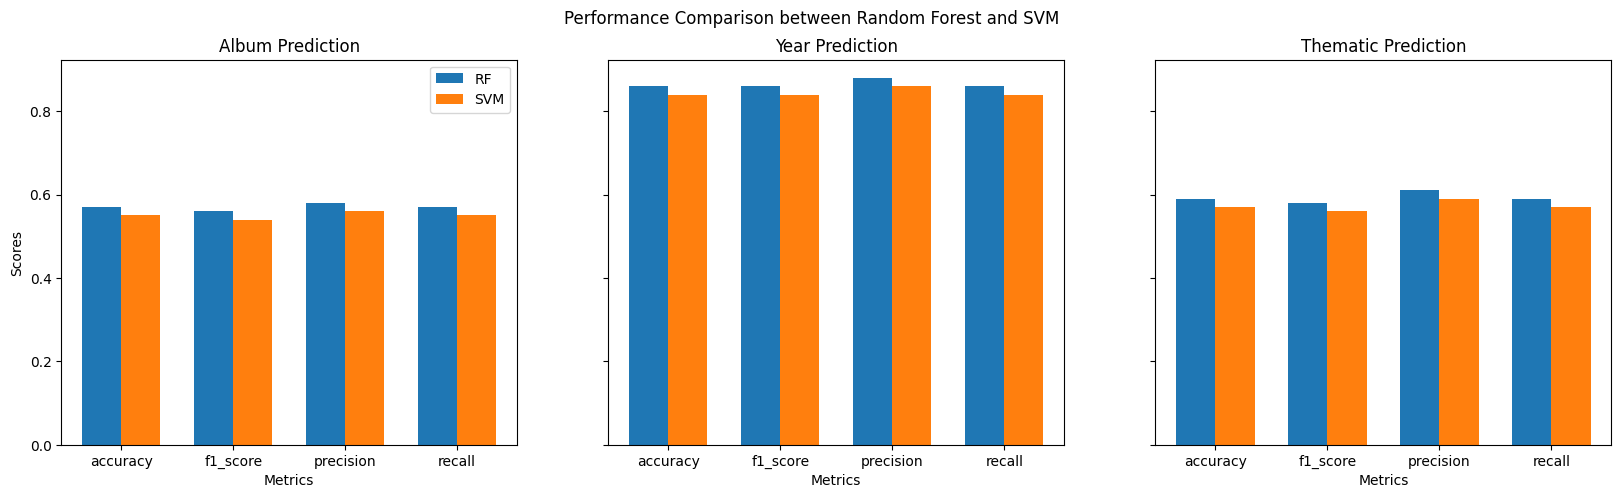

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Performance metrics for Random Forest
rf_metrics = {
    'Album': {'accuracy': 0.57, 'f1_score': 0.56, 'precision': 0.58, 'recall': 0.57},
    'Year': {'accuracy': 0.86, 'f1_score': 0.86, 'precision': 0.88, 'recall': 0.86},
    'Thematic': {'accuracy': 0.59, 'f1_score': 0.58, 'precision': 0.61, 'recall': 0.59}
}

# Performance metrics for SVM
svm_metrics = {
    'Album': {'accuracy': 0.55, 'f1_score': 0.54, 'precision': 0.56, 'recall': 0.55},
    'Year': {'accuracy': 0.84, 'f1_score': 0.84, 'precision': 0.86, 'recall': 0.84},
    'Thematic': {'accuracy': 0.57, 'f1_score': 0.56, 'precision': 0.59, 'recall': 0.57}
}

# Plot the metrics
metrics = ['accuracy', 'f1_score', 'precision', 'recall']
tasks = ['Album', 'Year', 'Thematic']

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for idx, task in enumerate(tasks):
    rf_values = [rf_metrics[task][metric] for metric in metrics]
    svm_values = [svm_metrics[task][metric] for metric in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35

    axes[idx].bar(x - width/2, rf_values, width, label='RF')
    axes[idx].bar(x + width/2, svm_values, width, label='SVM')

    axes[idx].set_xlabel('Metrics')
    axes[idx].set_title(f'{task} Prediction')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(metrics)

axes[0].set_ylabel('Scores')
fig.suptitle('Performance Comparison between Random Forest and SVM')
axes[0].legend()
plt.show()

In [14]:
# Function to test new lyrics with the trained models
def test_new_lyrics(lyrics, nmf_model, pca, rf_model_album, rf_model_year, rf_model_thematic, svm_model_album, svm_model_year, svm_model_thematic, tfidf_vectorizer):
    # Preprocess the lyrics
    processed_lyrics = preprocess_lyrics(lyrics)
    
    # Transform the lyrics using the TF-IDF vectorizer
    tfidf_features = tfidf_vectorizer.transform([processed_lyrics])
    
    # Transform the TF-IDF features using the NMF model
    nmf_features = nmf_model.transform(tfidf_features)
    
    # Apply PCA transformation
    pca_features = pca.transform(nmf_features)
    
    # Predict album, year, and thematic category using the Random Forest models
    album_rf_pred = rf_model_album.predict(pca_features)
    year_rf_pred = rf_model_year.predict(pca_features)
    thematic_rf_pred = rf_model_thematic.predict(pca_features)
    
    # Predict album, year, and thematic category using the SVM models
    album_svm_pred = svm_model_album.predict(pca_features)
    year_svm_pred = svm_model_year.predict(pca_features)
    thematic_svm_pred = svm_model_thematic.predict(pca_features)
    
    # Decode the predictions back to original labels
    album_rf_pred_decoded = label_encoder_album.inverse_transform(album_rf_pred)
    year_rf_pred_decoded = label_encoder_year.inverse_transform(year_rf_pred)
    thematic_rf_pred_decoded = label_encoder_thematic_category.inverse_transform(thematic_rf_pred)
    
    album_svm_pred_decoded = label_encoder_album.inverse_transform(album_svm_pred)
    year_svm_pred_decoded = label_encoder_year.inverse_transform(year_svm_pred)
    thematic_svm_pred_decoded = label_encoder_thematic_category.inverse_transform(thematic_svm_pred)
    
    print(f"Random Forest Predictions:\nAlbum: {album_rf_pred_decoded[0]}, Year: {year_rf_pred_decoded[0]}, Thematic Category: {thematic_rf_pred_decoded[0]}")
    print(f"SVM Predictions:\nAlbum: {album_svm_pred_decoded[0]}, Year: {year_svm_pred_decoded[0]}, Thematic Category: {thematic_svm_pred_decoded[0]}")

# Example usage with sample lyrics
sample_lyrics = "Say you'll remember me Standin' in a nice dress Starin' at the sunset, babe Red lips and rosy cheeks Say you'll see me again Even if it's just in your Wildest dreams, ah, ha Wildest dreams, ah, ha [Verse 2] I said, No one has to know what wе do His hands are in my hair, his clothes are in my room And his voicе is a familiar sound Nothin' lasts forever But this is gettin' good now See Taylor Swift LiveGet tickets as low as $60You might also like[Pre-Chorus] He's so tall and handsome as hell He's so bad, but he does it so well And when we've had our very last kiss My last request it is"
print(f"Sample lyrics-1: {sample_lyrics}")
print("\n")
test_new_lyrics(sample_lyrics, nmf_model, pca, best_rf_model_album, best_rf_model_year, best_rf_model_thematic, best_svm_model_album, best_svm_model_year, best_svm_model_thematic, tfidf_vectorizer)
print("\n")
print("------------------------------------------------------------------------------------------------------------------")
sample_lyrics2 = "We were both young when I first saw you I close my eyes and the flashback starts I'm standing there On a balcony in summer air See the lights, see the party, the ball gowns See you make your way through the crowd And say, Hello Little did I know [Pre-Chorus] That you were Romeo, you were throwing pebbles And my daddy said, Stay away from Juliet And I was crying on the staircase Begging you, Please don't go, and I said [Chorus] Romeo, take me somewhere we can be alone I'll be waiting, all there's left to do is run You'll be the prince and I'll be the princess It's a love story, baby, just say, Yes"
print(f"Sample lyrics-2: {sample_lyrics2}")
print("\n")
test_new_lyrics(sample_lyrics2, nmf_model, pca, best_rf_model_album, best_rf_model_year, best_rf_model_thematic, best_svm_model_album, best_svm_model_year, best_svm_model_thematic, tfidf_vectorizer)

Sample lyrics-1: Say you'll remember me Standin' in a nice dress Starin' at the sunset, babe Red lips and rosy cheeks Say you'll see me again Even if it's just in your Wildest dreams, ah, ha Wildest dreams, ah, ha [Verse 2] I said, No one has to know what wе do His hands are in my hair, his clothes are in my room And his voicе is a familiar sound Nothin' lasts forever But this is gettin' good now See Taylor Swift LiveGet tickets as low as $60You might also like[Pre-Chorus] He's so tall and handsome as hell He's so bad, but he does it so well And when we've had our very last kiss My last request it is


Random Forest Predictions:
Album: 1989, Year: 2024, Thematic Category: New Beginnings, Freedom
SVM Predictions:
Album: Folklore, Year: 2024, Thematic Category: Reflection, Storytelling


------------------------------------------------------------------------------------------------------------------
Sample lyrics-2: We were both young when I first saw you I close my eyes and the flashba